## Prepare train_data and test_data

In [1]:
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from hypergbm import make_experiment
from hypernets.tabular.metrics import metric_to_scoring
from sklearn.metrics import get_scorer

07-22 13:58:12 I hypernets.u._fsutils.py 300 - use /home/wumy/tmp/workdir as working directory.


In [2]:
X,y = datasets.load_breast_cancer(as_frame=True,return_X_y=True)
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=335)
train_data = pd.concat([X_train,y_train],axis=1)

# Add your own estimator(svm)

In [3]:
from hypergbm.pipeline import DataFrameMapper
from hypergbm.sklearn.sklearn_ops import numeric_pipeline_simple,categorical_pipeline_simple
from hypernets.core.ops import ModuleChoice, HyperInput
from hypernets.core.search_space import Choice, Int,Real
from hypernets.core.search_space import HyperSpace
from hypernets.tabular.column_selector import column_object
from hypergbm.estimators import HyperEstimator
from hypernets.utils import const
from sklearn import svm

## Define SVMEstimator

In [4]:
class SVMEstimator(HyperEstimator):
    def __init__(self, fit_kwargs, C=1.0, kernel='rbf', gamma='auto',degree=3,random_state=666,probability=True,
                 decision_function_shape=None,space=None, name=None, **kwargs):
        if C is not None:
            kwargs['C'] = C
        if kernel is not None:
            kwargs['kernel'] = kernel
        if gamma is not None:
            kwargs['gamma'] = gamma
        if degree is not None:
            kwargs['degree'] = degree
        if random_state is not None:
            kwargs['random_state'] = random_state
        if decision_function_shape is not None:
            kwargs['decision_function_shape'] = decision_function_shape
        kwargs['probability'] = probability
        HyperEstimator.__init__(self, fit_kwargs, space, name, **kwargs)
    def _build_estimator(self, task, kwargs):
        if task == const.TASK_REGRESSION:
            hsvm = SVMRegressorWrapper(**kwargs)
        else:
            hsvm = SVMClassifierWrapper(**kwargs)
        hsvm.__dict__['task'] = task
        return hsvm
class SVMClassifierWrapper(svm.SVC):
    def fit(self, X, y=None, **kwargs):
        return super().fit(X, y)
class SVMRegressorWrapper(svm.SVC):
    def fit(self, X, y=None, **kwargs):
        return super().fit(X, y)

## Define search_space

In [5]:
def search_space():
    space = HyperSpace()
    with space.as_default():
        input = HyperInput(name='input1')
        num_pipeline = numeric_pipeline_simple()(input)
        cat_pipeline = categorical_pipeline_simple()(input)
        union_pipeline = DataFrameMapper(default=False, input_df=True, df_out=True,
                                         df_out_dtype_transforms=[(column_object, 'int')])([num_pipeline, cat_pipeline])
        svm_init_kwargs = {
            'C': Real(0.1,5,0.1),
            'kernel':Choice(['rbf','poly','sigmoid']),
            'degree':Int(1,5),
            'gamma':Real(0.0001,5,0.0002)
        }
        svm_est =SVMEstimator(fit_kwargs={},**svm_init_kwargs)
        ModuleChoice([svm_est], name='estimator_options')(union_pipeline)
        space.set_inputs(input)
    return space

### Input Data

,X_train.shape,y_train.shape,X_eval.shape,y_eval.shape,X_test.shape,Task
0,"(398, 30)","(398,)",None,None,"(171, 30)",binary(2)


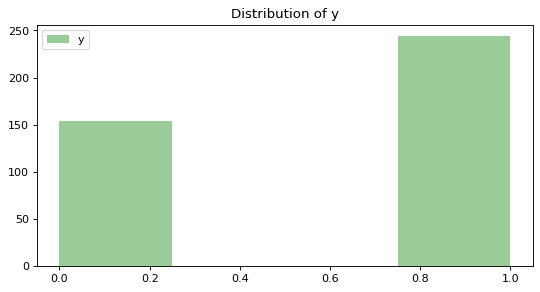

## Data Clean

### Initliazed parameters

,key,value
0,cv,True
1,data_cleaner_args,"{'nan_chars': None, 'correct_object_dtype': Tr..."
2,name,data_clean
3,random_state,9527
4,train_test_split_strategy,None


### Fitted parameters

,key,value
0,input_features,"[mean radius, mean texture, mean perimeter, me..."
1,selected_features,"[mean radius, mean texture, mean perimeter, me..."
2,unselected_features,[]
3,X_train.shape,"(398, 30)"
4,y_train.shape,"(398,)"
5,X_eval.shape,None
6,y_eval.shape,None
7,X_test.shape,"(171, 30)"
8,unselected_reason,{}
9,kept/dropped feature count,30/0


## Drift Detection

### Initliazed parameters

,key,value
0,min_features,10
1,name,drift_detection
2,num_folds,5
3,remove_shift_variable,True
4,remove_size,0.1
5,threshold,0.7
6,variable_shift_threshold,0.7


### Fitted parameters

,key,value
0,input_features,"[mean radius, mean texture, mean perimeter, me..."
1,selected_features,None
2,unselected_features,None
3,history,"[{'auc': 0.5483613445378152, 'n_features': 30,..."
4,scores,"{'mean radius': 0.6553921568627451, 'mean text..."


## Space Searching

### Initliazed parameters

,key,value
0,cv,True
1,name,space_searching
2,num_folds,3


#### Trials Summary:

,Trial No.,Previous reward,Best trial,Best reward,Total elapsed,Valid trials,Max trials
0,10,0.964824,3,0.967337,5.312066,10,10


#### Top trials:

,Trial No.,Reward,Elapsed,Space Vector
0,3,0.967337,0.081722,"[3.67, 1, 1.2501, 1]"
1,7,0.964824,0.088305,"[4.55, 1, 2.8901, 1]"
2,10,0.964824,0.088576,"[3.46, 1, 3.6701, 1]"
3,9,0.907035,0.084448,"[2.98, 2, 0.7201, 1]"
4,8,0.891960,0.192408,"[2.34, 2, 2.7201, 1]"


#### Best Trial:

key,value
signature,872d4cb1a83eb49fe5b334c71b9ae21a
vectors,"[3.67, 1, 1.2501, 1]"
0-Module_SVMEstimator_1.C,3.67
1-Module_SVMEstimator_1.kernel,poly
2-Module_SVMEstimator_1.gamma,1.2501
3-Module_SVMEstimator_1.degree,1


### Fitted parameters

,key,value
0,input_features,"[mean radius, mean texture, mean perimeter, me..."
1,best_reward,0.967337
2,history,<hypernets.core.trial.TrialHistory object at 0...


## Final Ensemble

### Initliazed parameters

,key,value
0,ensemble_size,20
1,name,final_ensemble
2,scorer,make_scorer(accuracy_score)


### Fitted parameters

,0,1
0,weights,"[0.7, 0.1, 0.1, 0.05, 0.05, 0.0, 0.0, 0.0, 0.0..."
1,scores,"[0.9673366834170855, 0.9723618090452262, 0.972..."
2,best_stack,"[0, 3, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, ..."
3,hits,"{0: 14, 3: 1, 1: 2, 2: 2, 4: 1}"
4,ensemble_size,20


In [6]:
experiment = make_experiment(train_data.copy(),target='target',test_data=X_test,
                             search_space=search_space)
estimator = experiment.run()

In [7]:
scorer = get_scorer(metric_to_scoring('precision',pos_label=1))
score = scorer(estimator, X_test, y_test)
score

0.9568965517241379

# Add SVM into GeneralSearchSpaceGenerator

In [8]:
from hypergbm.search_space import GeneralSearchSpaceGenerator
from hypergbm.estimators import XGBoostEstimator,LightGBMEstimator,CatBoostEstimator
class GeneralSearchSpaceGeneratorPlusSVM(GeneralSearchSpaceGenerator):
    def __init__(self,enable_svm=True, **kwargs):
        super(GeneralSearchSpaceGeneratorPlusSVM, self).__init__(**kwargs)
        self.enable_svm = enable_svm
    @property
    def default_svm_init_kwargs(self):
        return {
            'C': Real(0.1,5,0.1),
            'kernel':Choice(['rbf','poly','sigmoid']),
            'degree':Int(1,5),
            'gamma':Real(0.0001,5,0.0002)
        }
    @property
    def default_svm_fit_kwargs(self):
        return {}
    @property
    def estimators(self):
        r=super().estimators
        if self.enable_svm:
            r['svm'] = (SVMEstimator, self.default_svm_init_kwargs, self.default_svm_fit_kwargs)
        return r
generalSearchSpaceGeneratorPlusSVM = GeneralSearchSpaceGeneratorPlusSVM()

### Input Data

,X_train.shape,y_train.shape,X_eval.shape,y_eval.shape,X_test.shape,Task
0,"(398, 30)","(398,)",None,None,"(171, 30)",binary(2)


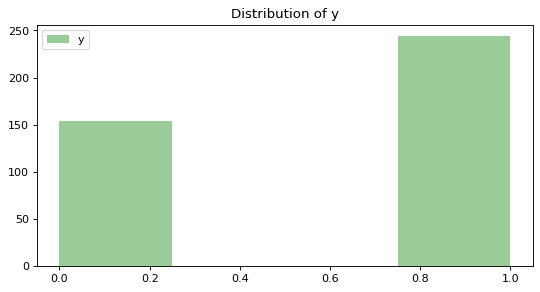

## Data Clean

### Initliazed parameters

,key,value
0,cv,True
1,data_cleaner_args,"{'nan_chars': None, 'correct_object_dtype': Tr..."
2,name,data_clean
3,random_state,9527
4,train_test_split_strategy,None


### Fitted parameters

,key,value
0,input_features,"[mean radius, mean texture, mean perimeter, me..."
1,selected_features,"[mean radius, mean texture, mean perimeter, me..."
2,unselected_features,[]
3,X_train.shape,"(398, 30)"
4,y_train.shape,"(398,)"
5,X_eval.shape,None
6,y_eval.shape,None
7,X_test.shape,"(171, 30)"
8,unselected_reason,{}
9,kept/dropped feature count,30/0


## Drift Detection

### Initliazed parameters

,key,value
0,min_features,10
1,name,drift_detection
2,num_folds,5
3,remove_shift_variable,True
4,remove_size,0.1
5,threshold,0.7
6,variable_shift_threshold,0.7


### Fitted parameters

,key,value
0,input_features,"[mean radius, mean texture, mean perimeter, me..."
1,selected_features,None
2,unselected_features,None
3,history,"[{'auc': 0.5483613445378152, 'n_features': 30,..."
4,scores,"{'mean radius': 0.6553921568627451, 'mean text..."


## Space Searching

### Initliazed parameters

,key,value
0,cv,True
1,name,space_searching
2,num_folds,3


#### Trials Summary:

,Trial No.,Previous reward,Best trial,Best reward,Total elapsed,Valid trials,Max trials
0,10,0.954774,1,0.967337,33.067308,10,10


#### Top trials:

,Trial No.,Reward,Elapsed,Space Vector
0,1,0.967337,5.354422,"[0, 1, 0, 2, 240, 2, 2, 2, 0, 1]"
1,3,0.967337,0.251668,"[0, 1, 1, 2, 365, 1, 2, 5, 2, 3, 0]"
2,4,0.967337,0.116939,"[3, 3, 1, 4.99, 1, 0.3301, 4, 3]"
3,7,0.959799,0.451448,"[2, 1, 1, 1, 2, 2, 0, 0]"
4,2,0.957286,9.211510,"[2, 2, 1, 4, 0, 3, 2, 1]"


#### Best Trial:

key,value
signature,e56afb71704bbcfe90377e93b9eca781
vectors,"[0, 1, 0, 2, 240, 2, 2, 2, 0, 1]"
0-estimator_options.hp_or,0
1-numeric_imputer_0.strategy,median
2-numeric_scaler_optional_0.hp_opt,False
3-Module_LightGBMEstimator_1.boosting_type,goss
4-Module_LightGBMEstimator_1.num_leaves,240
5-Module_LightGBMEstimator_1.max_depth,7
6-Module_LightGBMEstimator_1.learning_rate,0.5
7-Module_LightGBMEstimator_1.n_estimators,50


### Fitted parameters

,key,value
0,input_features,"[mean radius, mean texture, mean perimeter, me..."
1,best_reward,0.967337
2,history,<hypernets.core.trial.TrialHistory object at 0...


## Final Ensemble

### Initliazed parameters

,key,value
0,ensemble_size,20
1,name,final_ensemble
2,scorer,make_scorer(accuracy_score)


### Fitted parameters

,0,1
0,weights,"[0.7, 0.1, 0.1, 0.05, 0.05, 0.0, 0.0, 0.0, 0.0..."
1,scores,"[0.9673366834170855, 0.9723618090452262, 0.972..."
2,best_stack,"[0, 3, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, ..."
3,hits,"{0: 14, 3: 1, 1: 2, 2: 2, 4: 1}"
4,ensemble_size,20


In [9]:
experiment = make_experiment(train_data.copy(),target='target',test_data=X_test,
                             search_space=generalSearchSpaceGeneratorPlusSVM)
estimator = experiment.run()

In [10]:
scorer = get_scorer(metric_to_scoring('precision',pos_label=1))
score = scorer(estimator, X_test, y_test)
score

0.9646017699115044